In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy.stats import zscore
import umap
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import subprocess as sp
import os
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_simulations/utils/')
from scipy.special import logit, expit
from scipy.stats import norm
from matplotlib import pyplot as plt

sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_tools/preprocess_utils')
from table_utils import *

from sklearn.neighbors import NearestNeighbors

import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def simulate_observed_psi(reads_table_path, gene_len_file, n=500, g=1500, read_len=50, anchor_len=1, 
                          header=False, index=False, out_dir = 'processed_tables/', extension=''):
    '''
    input:
    * reads_table_path (str): path to the table with isoform read counts. 
      Should have a (2g,n) dimension.
    * n (int): number of cells in the simulation (columns)
    * g (int): number of genes in the simulation. Isoforms are 2g.
    * read_len (int): length of sequencing reads simulated. Here we simulate single-end sequencing.
    * anchor_len (int >= 1): length of nucleotides required to overlap a splice junction.
    
    output:
    * observed_psi (df): dataframe (g,n) with observed PSI, estimated as included_reads/(included_reads + 2* excluded_reads)
        NA for cases where reads_i + reads_e == 0.
        This table is what you normally would observe in the data, and it's a distorted picture of true_psi
    * reads_i (df): dataframe (g,n) with counts of reads that cover informative splice junctions for mRNAs that include the exon.
        We do not make a difference between either splice junction, but that could be modeled later.
    * reads_e (df): dataframe (g,n) with counts of reads that cover informative splice junctions for mRNAs that exclude the exon.
      
    Description:    
      Get the observed ratio of isoform reads from SymSim output.
      No splicing junction downsampling.
    
      Assumes that the original table's shape is (n, 2g). The first 
      g rows correspond to the "included" isoforms. The latter g rows
      correspond to the "excluded" isoform (order is preserved).
    
      Originally used for reads before I realized the bias SymSim introduces 
      when gene length is set as constant.
    
      Used to get the true PSI of each exon in each cell.
    '''
    
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    
    gene_len = np.array([int(x.rstrip()) for x in open(gene_len_file).readlines()])

    
    np.random.seed(0)
    
    if anchor_len < 1:
        raise Exception('Anchor length has to be at least 1 nt long.')
    
    gene_len_i = gene_len[:g]
    gene_len_e = gene_len[g:(2*g)]
    
    biases_i = (2*(read_len-anchor_len))/gene_len_i
    biases_e = (2*(read_len-anchor_len))/gene_len_e
    
    if header and index:
        print('prueba')
        reads_table = pd.read_csv(reads_table_path, sep='\t', index_col=0).astype(float)
        reads_table.columns = ['cell_' + str(i) for i in range(1, n+1)]
    elif header and not index:
        reads_table = pd.read_csv(reads_table_path, sep='\t', index_col=None).astype(float)
    else:
        reads_table = pd.read_csv(reads_table_path, sep='\t', names = ['cell_' + str(i) for i in range(1, n+1)]).astype(float)
    
    reads_table.index = range(len(reads_table.index))
    
    i = reads_table.iloc[:g]
    e = reads_table.iloc[g:(2*g)].reset_index(drop=True)
    
    adj_reads_table = reads_table.divide(gene_len, axis=0)
    
    tpm_isoforms = 1e6*(adj_reads_table.divide(adj_reads_table.sum()))
    
    tpm_i = tpm_isoforms.iloc[:g]
    tpm_e = tpm_isoforms.iloc[g:(2*g)].reset_index(drop=True)
    
    tpm = tpm_i + tpm_e
    
    total_observed_reads= pd.DataFrame(i+e)
    
    
    reads_i1 = pd.DataFrame(np.array([np.random.binomial(i.loc[x], biases_i[x]) for x in i.index]))
    reads_i2 = pd.DataFrame(np.array([np.random.binomial(i.loc[x], biases_i[x]) for x in i.index]))
    reads_e = pd.DataFrame(np.array([np.random.binomial(e.loc[x], biases_e[x]) for x in e.index]))
    
    reads_i = reads_i1 + reads_i2

    observed_psi = reads_i/(reads_i + 2*reads_e)
    
    cells = ['cell_' + str(i) for i in range(1, n+1)]
    genes = ['gene' + str(i) for i in range(1, g+1)]
    
    total_observed_reads.index = genes
    total_observed_reads.columns = cells
    
    tpm.index = genes
    tpm.columns = cells

    observed_psi.index = genes
    reads_i1.index = [x + '_I1' for x in genes]
    reads_i2.index = [x + '_I2' for x in genes]
    reads_e.index = [x + '_SE' for x in genes]
    
    observed_psi.columns = cells
    reads_i1.columns = cells
    reads_i2.columns = cells
    reads_e.columns = cells
    
    splice_junction_reads = pd.concat((reads_i1, reads_i2, reads_e))
    
    
        
    biases_const_i = (2*(read_len-anchor_len))/gene_len_i
    biases_const_e = (2*(read_len-anchor_len))/gene_len_e

    reads_const_i = pd.DataFrame(np.array([np.random.binomial(i.loc[x], biases_const_i[x]) for x in i.index]))
    reads_const_e = pd.DataFrame(np.array([np.random.binomial(e.loc[x], biases_const_e[x]) for x in e.index]))

    reads_const = reads_const_i + reads_const_e 

    reads_const.index = [x + '_CI' for x in genes]
    reads_const.columns = cells
    
    
    observed_psi.to_csv(out_dir + 'psi_observed{ext}.tab.gz'.format(ext=extension), sep='\t', index=True, header=True)
    splice_junction_reads.to_csv(out_dir + 'SE_counts{ext}.tab.gz'.format(ext=extension), sep='\t', index=True, header=True)
    reads_const.to_csv(out_dir + 'constitutive_introns{ext}.tab.gz'.format(ext=extension), sep='\t', index=True, header=True)
    total_observed_reads.to_csv(out_dir + 'observed_counts{ext}.tab.gz'.format(ext=extension), 
                                sep='\t', index=True, header=True)
    tpm.to_csv(out_dir + 'tpm{ext}.tab.gz'.format(ext=extension), sep='\t', index=True, header=True)
        
        

In [12]:
# simulate_observed_psi('sim_output/observed_counts_0.1.tab', 
#     'sim_output/isoform_length.txt', 
#     n=1000, g=5000, out_dir = 'processed_tables/', extension='_0.1')

# simulate_observed_psi('sim_output/observed_counts_0.05.tab', 
#     'sim_output/isoform_length.txt', 
#     n=1000, g=5000, out_dir = 'processed_tables/', extension='_0.05')

# simulate_observed_psi('sim_output/observed_counts_0.01.tab', 
#     'sim_output/isoform_length.txt', 
#     n=1000, g=5000, out_dir = 'processed_tables/', extension='_0.01')

In [3]:
gene_counts = pd.read_csv('sim_output/gene_counts.tab.gz', sep='\t',
                         names = ['cells_'+str(i+1) for i in range(1000)])
gene_counts.index = ['gene' + str(i+1) for i in range(5000)]

meta = pd.read_csv('sim_output/meta.tab.gz', sep='\t')
meta.index=gene_counts.columns

from sklearn.preprocessing import StandardScaler
scaled_counts = StandardScaler().fit_transform(np.log1p(gene_counts).T).T

Text(0.5, 1.0, 'single lineage')

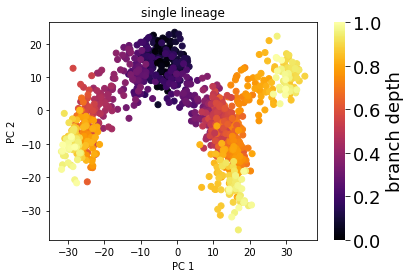

In [5]:
from sklearn.preprocessing import StandardScaler
scaled_counts = StandardScaler().fit_transform(np.log1p(gene_counts).T).T

pca_mrna = PCA(n_components=10)
pca_mrna = pca_mrna.fit_transform(scaled_counts.T)


fig = plt.figure()
ax = fig.add_subplot(111)

sc = plt.scatter(pca_mrna.T[0], -pca_mrna.T[1], c=meta.depth, cmap='inferno')
cb = plt.colorbar(sc)
cb.set_label(label='branch depth',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('single lineage')

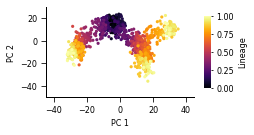

In [28]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

# os.mkdir('sub_plots/')
fig = plt.figure(figsize=(8/2.4, 4/2.4))
ax = fig.add_subplot(111)

sc = ax.scatter(pca_mrna.T[0], -pca_mrna.T[1], c=meta.depth, cmap='inferno', vmin=0, s=10, linewidth=0)
cb = plt.colorbar(sc, shrink = 0.8, aspect=10)#, orientation="horizontal")
cb.set_label(label='Lineage',size=8)
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=8, length=2)



ax.tick_params(labelsize=8, length=5)

ax.set_xlabel('PC 1', size=8)
ax.set_ylabel('PC 2', size=8)

# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,
#     left = False,
#     right = False, # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
# labelleft=False)

# ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_xticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=18)
# ax.set_xlabel('PC 1', size=8)
# ax.set_ylabel('PC 2', size=8)

# ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=18)
# ax.set_ylabel('p-values', size=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlim([-45, 45])
ax.set_ylim([-50, 30])

# ax.spines["left"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

# ax.legend(frameon=False, fontsize=18)

plt.savefig('../plots/three_lineages.png', bbox_inches='tight', res=20000, dpi =2000)

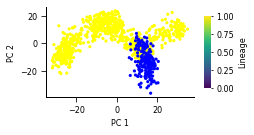

In [22]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

# os.mkdir('sub_plots/')
fig = plt.figure(figsize=(8/2.4, 4/2.4))
ax = fig.add_subplot(111)

sc = ax.scatter(pca_mrna.T[0], -pca_mrna.T[1], c=['blue' if x == '5_3' else 'yellow' for x in meta['pop']], cmap='inferno', vmin=0, s=10, linewidth=0)
cb = plt.colorbar(sc, shrink = 0.8, aspect=10)#, orientation="horizontal")
cb.set_label(label='Lineage',size=8)
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=8, length=2)



ax.tick_params(labelsize=8, length=5)

ax.set_xlabel('PC 1', size=8)
ax.set_ylabel('PC 2', size=8)

# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,
#     left = False,
#     right = False, # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
# labelleft=False)

# ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_xticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=18)
# ax.set_xlabel('PC 1', size=8)
# ax.set_ylabel('PC 2', size=8)

# ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=18)
# ax.set_ylabel('p-values', size=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# ax.spines["left"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

# ax.legend(frameon=False, fontsize=18)

# plt.savefig('sub_plots/three_lineages.png', bbox_inches='tight', res=20000, dpi =2000)

<IPython.core.display.Javascript object>


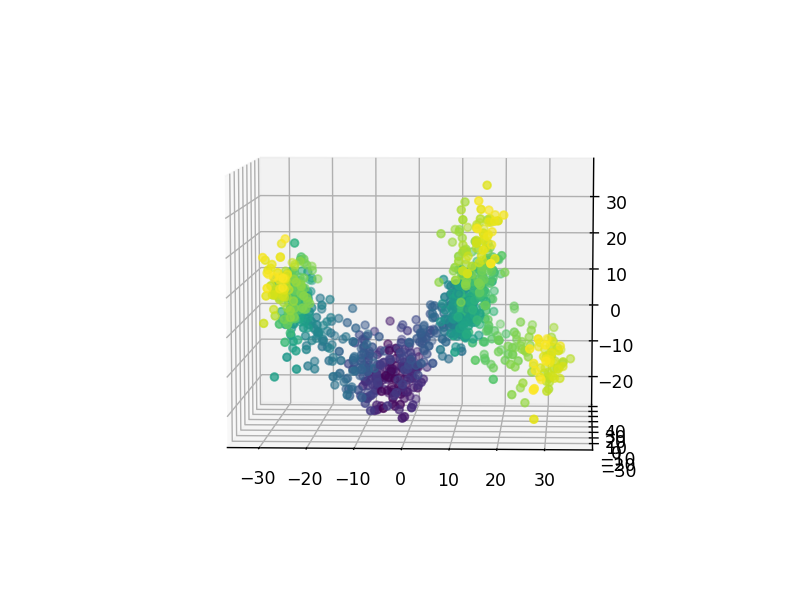

In [15]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_mrna.T[0], pca_mrna.T[2], pca_mrna.T[1], c=meta.depth)

In [16]:
rd = pd.DataFrame(pca_mrna, index = ['cell_' + str(i) for i in range(1, 1001)],
                 columns = ['PC_' + str(i) for i in range(1, 11)])
rd[['PC_1', 'PC_2', 'PC_3']].to_csv('processed_tables/pc3_rd.tab.gz', index=True, header=True, sep='\t')

In [17]:
rd = pd.DataFrame(pca_mrna, index = ['cell_' + str(i) for i in range(1, 1001)],
                 columns = ['PC_' + str(i) for i in range(1, 11)])
rd[['PC_1', 'PC_2']].to_csv('processed_tables/pc2_rd.tab.gz', index=True, header=True, sep='\t')

In [2]:
splice_junction_reads = pd.read_csv('processed_tables/SE_counts_0.1.tab.gz', 
                                    sep='\t', index_col=0)
reads_const = pd.read_csv('processed_tables/constitutive_introns_0.1.tab.gz', sep='\t', index_col=0)

pd.concat([splice_junction_reads, reads_const]).to_csv('processed_tables/splice_junction_counts_0.1.tab.gz', sep='\t',
                                                      index=True, header=True)


splice_junction_reads = pd.read_csv('processed_tables/SE_counts_0.05.tab.gz', 
                                    sep='\t', index_col=0)
reads_const = pd.read_csv('processed_tables/constitutive_introns_0.05.tab.gz', sep='\t', index_col=0)

pd.concat([splice_junction_reads, reads_const]).to_csv('processed_tables/splice_junction_counts_0.05.tab.gz', sep='\t',
                                                      index=True, header=True)

splice_junction_reads = pd.read_csv('processed_tables/SE_counts_0.01.tab.gz', 
                                    sep='\t', index_col=0)
reads_const = pd.read_csv('processed_tables/constitutive_introns_0.01.tab.gz', sep='\t', index_col=0)

pd.concat([splice_junction_reads, reads_const]).to_csv('processed_tables/splice_junction_counts_0.01.tab.gz', sep='\t',
                                                      index=True, header=True)